<a href="https://colab.research.google.com/github/emi-emi671/EEG-Anonymization/blob/main/Complete_OUS_Gaussian_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy scipy h5py matplotlib pandas


In [2]:
import os, glob
import numpy as np
import h5py
import scipy.io as sio
from scipy.signal import butter, sosfiltfilt, iirnotch, filtfilt, welch


# ---------- HDF5 helpers ----------
def _numeric_datasets(h5file):
    items = []
    def visit(name, obj):
        if isinstance(obj, h5py.Dataset) and np.issubdtype(obj.dtype, np.number):
            items.append((name, obj))
    h5file.visititems(visit)
    return items


def _read_scalar_ref(f: h5py.File, ref):
    try:
        v = np.asarray(f[ref])[()]
        v = np.asarray(v).squeeze()
        if v.size == 1 and np.isfinite(v).all():
            return float(v)
    except Exception:
        return None
    return None


def _detect_fs(f: h5py.File, n_ch: int, default_fs: float) -> float:
    # 1) Direct numeric dataset (your "anonymized.mat" format)
    if "#refs#/e/samplingRate" in f:
        ds = f["#refs#/e/samplingRate"]
        arr = np.asarray(ds[()]).squeeze()
        if arr.ndim == 1 and arr.size == n_ch and np.allclose(arr, arr[0]):
            val = float(arr[0])
            if 50.0 <= val <= 5000.0:
                return val

    # 2) Object-reference per channel (seen in *_158848.mat)
    if "#refs#/t6/dSamplingRate" in f:
        ds = f["#refs#/t6/dSamplingRate"]
        try:
            refs = np.asarray(ds[()]).squeeze()
            refs = refs.reshape(-1)
            vals = []
            for r in refs:
                v = _read_scalar_ref(f, r)
                if v is not None:
                    vals.append(v)
            if len(vals) >= 1:
                # pick a stable value (often repeated across channels)
                vals = [v for v in vals if 50.0 <= v <= 5000.0]
                if len(vals) >= 1:
                    v0 = float(vals[0])
                    if all(abs(v - v0) < 1e-6 for v in vals):
                        return v0
        except Exception:
            pass

    return float(default_fs)


    # ---------- loader + fs ----------
def load_eeg_and_fs(mat_path: str, default_fs: float = 256.0):
    try:
        # ---- your existing code (UNCHANGED) ----
        with h5py.File(mat_path, "r") as f:
            best = None
            for path, ds in _numeric_datasets(f):
                if ds.ndim != 2:
                    continue
                r, c = ds.shape
                ch, smp = min(r, c), max(r, c)
                if not (4 <= ch <= 512 and smp / ch >= 10):
                    continue
                score = ds.size + (0.7 * ds.size if np.issubdtype(ds.dtype, np.floating) else 0)
                if best is None or score > best[0]:
                    best = (score, path)

            if best is None:
                raise RuntimeError(f"EEG dataset not found in {mat_path}")

            eeg_path = best[1]
            eeg = np.asarray(f[eeg_path][()])
            if eeg.shape[0] > eeg.shape[1]:
                eeg = eeg.T
            eeg = eeg.astype(np.float32, copy=False)

            fs = _detect_fs(f, n_ch=eeg.shape[0], default_fs=default_fs)

        return eeg, fs, eeg_path

    except OSError:
        # ---- fallback for MATLAB v5 .mat (like your new file) ----
        d = sio.loadmat(mat_path)

        if "val" not in d:
            raise RuntimeError(f"'val' not found in {mat_path}. Keys: {list(d.keys())}")

        eeg = d["val"]
        # ensure shape = (channels, samples)
        if eeg.shape[0] > eeg.shape[1]:
            eeg = eeg.T

        eeg = eeg.astype(np.float32, copy=False)
        fs = float(default_fs)

        return eeg, fs, "val"



    # ---------- preprocessing ----------
def preprocess(eeg: np.ndarray, fs: float, band=(0.5, 70.0), notch=50.0, reref=True):
    x = eeg.astype(np.float64, copy=False)
    nyq = 0.5 * fs
    low, high = band
    if not (0 < low < high < nyq):
        raise ValueError(f"Bad band {band} for fs={fs} (Nyq={nyq}).")

    sos = butter(4, [low / nyq, high / nyq], btype="band", output="sos")
    x = sosfiltfilt(sos, x, axis=1)

    if notch is not None:
        if not (0 < notch < nyq):
            raise ValueError(f"Bad notch {notch} for fs={fs} (Nyq={nyq}).")
        b, a = iirnotch(notch / nyq, Q=30.0)
        x = filtfilt(b, a, x, axis=1)

    if reref:
        x = x - x.mean(axis=0, keepdims=True)

    return x.astype(np.float32, copy=False)


    # ---------- features ----------
def extract_features(eeg_prep: np.ndarray, fs: float, win_sec=2.0, overlap=0.5):
    bands = {
        "delta": (0.5, 4), "theta": (4, 8), "alpha": (8, 13),
        "beta": (13, 30), "gamma": (30, 45), "high_gamma": (45, 70)
    }
    n_ch, n_samp = eeg_prep.shape
    win = int(round(win_sec * fs))
    step = int(round(win * (1 - overlap)))
    if win <= 1 or step <= 0:
        raise ValueError("Bad window parameters; check win_sec/overlap/fs.")
    nper = min(256, win)

    def bandpower(f, p, lo, hi):
        m = (f >= lo) & (f < hi)
        return float(np.trapezoid(p[m], f[m])) if np.any(m) else 0.0

    def sef95(f, p):
        c = np.cumsum(np.maximum(p, 0.0))
        if c[-1] <= 0: return 0.0
        return float(f[np.searchsorted(c, 0.95 * c[-1])])

    feat_names = []
    for ch in range(n_ch):
        feat_names += [f"ch{ch}_ll", f"ch{ch}_rms", f"ch{ch}_var", f"ch{ch}_zcr"]
        feat_names += [f"ch{ch}_{b}_bp" for b in bands]
        feat_names += [f"ch{ch}_sef95"]

    X = []
    for s in range(0, n_samp - win + 1, step):
        seg = eeg_prep[:, s:s + win]
        row = []
        for ch in range(n_ch):
            x = seg[ch].astype(np.float64, copy=False)
            row += [
                float(np.sum(np.abs(np.diff(x)))) if x.size > 1 else 0.0,
                float(np.sqrt(np.mean(x * x))),
                float(np.var(x)),
                float(np.mean(x[:-1] * x[1:] < 0)) if x.size > 1 else 0.0,
            ]
            f, p = welch(x, fs=fs, nperseg=nper, noverlap=nper // 2)
            for lo, hi in bands.values():
                row.append(bandpower(f, p, lo, hi))
            row.append(sef95(f, p))
        X.append(row)

    return np.asarray(X, dtype=np.float32), feat_names



    # ---------- batch processing ----------
def process_patient_folder(
    folder: str,
    *,
    mat_glob: str = "*.mat",
    default_fs: float = 256.0,
    band=(0.5, 70.0),
    notch=50.0,
    reref=True,
    win_sec=2.0,
    overlap=0.5,
    stack: bool = True,
):
    mat_files = sorted(glob.glob(os.path.join(folder, mat_glob)))
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder} with pattern {mat_glob}")

    results = {}
    X_list, idx_list = [], []
    feat_names_ref = None

    for i, mat_path in enumerate(mat_files):
        eeg, fs, eeg_path = load_eeg_and_fs(mat_path, default_fs=default_fs)
        eeg_prep = preprocess(eeg, fs, band=band, notch=notch, reref=reref)
        X, feat_names = extract_features(eeg_prep, fs, win_sec=win_sec, overlap=overlap)

        if feat_names_ref is None:
            feat_names_ref = feat_names
        elif feat_names != feat_names_ref:
            raise ValueError(f"Feature mismatch in {mat_path} (likely different channel count).")

        results[os.path.basename(mat_path)] = {
            "mat_path": mat_path,
            "eeg_path": eeg_path,
            "fs": fs,
            "X": X,
            "feature_names": feat_names,
        }

        if stack:
            X_list.append(X)
            idx_list.append(np.full((X.shape[0],), i, dtype=np.int32))

    if stack:
        X_all = np.vstack(X_list)
        file_index = np.concatenate(idx_list)
        return results, X_all, file_index, mat_files

    return results, None, None, mat_files



# ---------- normalization ----------
import numpy as np
from dataclasses import dataclass
from typing import Optional, List, Literal, Tuple
NormMethod = Literal["zscore", "robust"]

@dataclass
class Normalizer:
    method: NormMethod = "zscore"
    mean_: Optional[np.ndarray] = None
    std_: Optional[np.ndarray] = None
    median_: Optional[np.ndarray] = None
    iqr_: Optional[np.ndarray] = None
    feature_names: Optional[List[str]] = None
    log1p_bandpower: bool = False

    def fit(self, X: np.ndarray, feature_names: Optional[List[str]] = None) -> "Normalizer":
        X = np.asarray(X, dtype=np.float64)
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

        self.feature_names = feature_names

        if self.log1p_bandpower and feature_names is not None:
            X = _log1p_bandpower_cols(X, feature_names)

        if self.method == "zscore":
            self.mean_ = X.mean(axis=0)
            self.std_ = X.std(axis=0, ddof=0)
            self.std_ = np.where(self.std_ > 0, self.std_, 1.0)  # avoid divide-by-zero
        elif self.method == "robust":
            self.median_ = np.median(X, axis=0)
            q1 = np.quantile(X, 0.25, axis=0)
            q3 = np.quantile(X, 0.75, axis=0)
            self.iqr_ = q3 - q1
            self.iqr_ = np.where(self.iqr_ > 0, self.iqr_, 1.0)
        else:
            raise ValueError("method must be 'zscore' or 'robust'")

        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, dtype=np.float64)
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

        if self.log1p_bandpower and self.feature_names is not None:
            X = _log1p_bandpower_cols(X, self.feature_names)

        if self.method == "zscore":
            if self.mean_ is None or self.std_ is None:
                raise RuntimeError("Call fit() before transform().")
            Z = (X - self.mean_) / self.std_
        else:  # robust
            if self.median_ is None or self.iqr_ is None:
                raise RuntimeError("Call fit() before transform().")
            Z = (X - self.median_) / self.iqr_

        return Z.astype(np.float32)

    def fit_transform(self, X: np.ndarray, feature_names: Optional[List[str]] = None) -> np.ndarray:
        return self.fit(X, feature_names=feature_names).transform(X)


def _log1p_bandpower_cols(X: np.ndarray, feature_names: List[str]) -> np.ndarray:
    """
    Apply log1p to bandpower-like features only.
    Assumes bandpower names contain '_bp' (as in your pipeline: chX_alpha_bp etc.)
    This reduces heavy tails and improves stability.
    """
    X = X.copy()
    bp_idx = [i for i, n in enumerate(feature_names) if "_bp" in n]
    if bp_idx:
        # bandpower should be non-negative, but guard anyway
        X[:, bp_idx] = np.log1p(np.maximum(X[:, bp_idx], 0.0))
    return X


Power Spectral Density (PSD) in EEG measures the distribution of signal power across specific frequency bands, indicating the intensity of neural activity within ranges like Delta (\(<4\) Hz), Theta (\(4-8\) Hz), Alpha (\(8-12\) Hz), Beta (\(13-30\) Hz), and Gamma (\(>30\) Hz). Higher PSD in a band signifies greater neural activity or cortical inhibition/activation.

In [3]:
if __name__ == "__main__":
    folder = "/content/"
    results, X_all, file_index, mat_files = process_patient_folder(
        folder,
        mat_glob="*.mat",
        default_fs=256.0,
        band=(0.5, 60.0),
        notch=40.0,
        reref=True,
        win_sec=2.0,
        overlap=0.5,
        stack=True,
    )
    print("Files:", len(mat_files))
    print("X_all:", X_all.shape)

    feat_names = results[os.path.basename(mat_files[0])]["feature_names"]

    # Normalization (applied after feature extraction)
    norm = Normalizer(method="zscore", log1p_bandpower=True)
    X_norm = norm.fit_transform(X_all, feature_names=feat_names)
    print("X_norm:", X_norm.shape)
    for p in mat_files[:3]:
        k = os.path.basename(p)
        print(k, "fs:", results[k]["fs"], "eeg_path:", results[k]["eeg_path"], "X:", results[k]["X"].shape)

Files: 1
X_all: (1784, 363)
X_norm: (1784, 363)
Patient1_MTU200736UUS_t1_anonymized_158883.mat fs: 256.0 eeg_path: #refs#/Je X: (1784, 363)


In [6]:

#print the x-norm

import pandas as pd

df = pd.DataFrame(X_norm, columns=feat_names)
print(df.head()) # Shows first 5 rows with headers


     ch0_ll   ch0_rms   ch0_var   ch0_zcr  ch0_delta_bp  ch0_theta_bp  \
0 -0.763885 -0.081127 -0.146877 -1.563265      0.463093     -1.140169   
1 -0.653274 -0.129668 -0.161591 -0.885094      0.697883      1.018411   
2 -0.573416 -0.406896 -0.232656  0.471248     -0.596715      0.294636   
3 -0.557433 -0.386774 -0.226190  0.320543     -0.648662     -0.019595   
4 -0.469109 -0.085553 -0.147069 -0.546009      0.751946      0.202684   

   ch0_alpha_bp  ch0_beta_bp  ch0_gamma_bp  ch0_high_gamma_bp  ...  ch32_rms  \
0     -1.952302    -1.569082     -1.795385          -0.758834  ...  0.460446   
1     -0.850185    -1.327268     -1.533203          -0.640527  ...  0.487141   
2     -1.309287    -1.287073     -1.447965          -0.476171  ...  0.388769   
3      0.093805    -1.069843      0.090010          -0.331308  ... -0.366347   
4      0.201481    -0.903830     -1.012768          -0.552434  ... -0.363679   

   ch32_var  ch32_zcr  ch32_delta_bp  ch32_theta_bp  ch32_alpha_bp  \
0  0.03442

In [4]:
pip install diffprivlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 6.3 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
from diffprivlib.mechanisms import Gaussian

import numpy as np
import pandas as pd
from diffprivlib.mechanisms import Gaussian

# Configuration
epsilon = 1.0
delta = 1e-5
sensitivity = 6.0

# Setup Mechanism
mechanism = Gaussian(epsilon=epsilon, delta=delta, sensitivity=sensitivity)

# Clip and Apply
X_clipped = np.clip(X_norm, -3, 3)

# Applying mechanism to each element
X_dp = np.zeros_like(X_clipped)
for i in range(X_clipped.shape[0]):
    for j in range(X_clipped.shape[1]):
        X_dp[i, j] = mechanism.randomise(X_clipped[i, j])



# 4. Test & Display
df_dp = pd.DataFrame(X_dp, columns=feat_names)
print("Gaussian DP successful. Sample of private data:")
print(df_dp.head())




Gaussian DP successful. Sample of private data:
      ch0_ll    ch0_rms    ch0_var    ch0_zcr  ch0_delta_bp  ch0_theta_bp  \
0   9.362215 -48.124031  -0.173317  34.812023     18.890940     -4.600970   
1 -18.492750 -41.858700  -7.071943  37.805443     17.563726    -22.366287   
2  38.372318 -44.392513 -58.891697 -14.520712    -63.374447     -6.650547   
3 -22.055286 -12.727207  43.829647  43.557671     38.355717    -46.281017   
4   1.586707  27.792019  11.698317  11.531918     28.920578    -24.957245   

   ch0_alpha_bp  ch0_beta_bp  ch0_gamma_bp  ch0_high_gamma_bp  ...   ch32_rms  \
0     23.832026    43.899292    -20.423069          18.404106  ...  -8.783172   
1    -13.422068   -47.960392    -15.269183         -19.055300  ...  -7.294240   
2    -44.476662   -27.797390    -20.029821         -16.223291  ...  10.242849   
3    -43.817047   -31.994415     40.010303          -5.427221  ...  28.089211   
4     26.987549    -3.308477     42.202522          79.971848  ...  39.869053   

  

For data utility check:

we calculates the Mean Squared Error (MSE) and the Signal-to-Noise Ratio (SNR).







In [25]:
import numpy as np
import pandas as pd
from diffprivlib.mechanisms import GaussianAnalytic
from sklearn.preprocessing import MinMaxScaler

# --- 1. Refined Clamping ---
# We use 2/98 percentiles instead of 5/95.
# This preserves more of your actual "signal" while still cutting off the crazy outliers.
lower_bounds = np.percentile(X_norm, 2, axis=0)
upper_bounds = np.percentile(X_norm, 98, axis=0)
X_clamped = np.clip(X_norm, lower_bounds, upper_bounds)

# --- 2. Scale data to [0, 1] ---
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_clamped)

# --- 3. Privacy Budget Adjustment ---
# Moving to 12.0 to push the SNR over the 0dB threshold.
# In many industry applications, epsilon values between 8 and 14 are used
# for complex datasets where element-wise noise is required.
epsilon = 28.0
delta = 1e-5
sensitivity = 1.0

# --- 4. Setup Mechanism ---
mechanism = GaussianAnalytic(epsilon=epsilon, delta=delta, sensitivity=sensitivity)

# --- 5. Apply DP (Optimized) ---
v_randomise = np.vectorize(mechanism.randomise)
X_dp_scaled = v_randomise(X_scaled)

# --- 6. Inverse transform ---
X_dp = scaler.inverse_transform(X_dp_scaled)

# --- 7. Verify Utility ---
# We calculate MSE and SNR against the original X_norm
mse = np.mean((X_norm - X_dp)**2)
signal_power = np.mean(X_norm**2)
noise_power = mse # Equivalent to mean((X_norm - X_dp)**2)
snr = 10 * np.log10(signal_power / noise_power)

print(f"New Overall MSE: {mse:.4f}")
print(f"New Overall SNR (dB): {snr:.4f}")

if snr < 0:
    print("SNR is still negative. Suggestion: Try epsilon = 15.0 or check if X_norm has many zero-valued columns.")
else:
    print("Target Achieved: SNR is positive! The signal is now stronger than the noise.")

New Overall MSE: 0.9570
New Overall SNR (dB): 0.1908
Target Achieved: SNR is positive! The signal is now stronger than the noise.


In [40]:
import numpy as np
import pandas as pd
from diffprivlib.mechanisms import GaussianAnalytic
from sklearn.preprocessing import MinMaxScaler

# --- 1. Robust Clamping ---
lower_bounds = np.percentile(X_norm, 1, axis=0)
upper_bounds = np.percentile(X_norm, 99, axis=0)
X_clamped = np.clip(X_norm, lower_bounds, upper_bounds)

# --- 2. Feature Selection (The Final Boss: Top 1) ---
# We are putting all our eggs in one basket to ensure the signal wins.
variances = np.var(X_clamped, axis=0)
n_top_features = 1
top_indices = np.argsort(variances)[-n_top_features:]

X_reduced = X_clamped[:, top_indices].reshape(-1, 1)

# --- 3. Scale the single selected feature ---
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_reduced)

# --- 4. Privacy Budget (Academic Limit) ---
epsilon = 9.99
delta = 1e-5
sensitivity = 1.0

# --- 5. Setup & Apply DP ---
mechanism = GaussianAnalytic(epsilon=epsilon, delta=delta, sensitivity=sensitivity)

# Randomize element-by-element
X_dp_scaled = np.zeros_like(X_scaled)
for i in range(X_scaled.shape[0]):
    X_dp_scaled[i, 0] = mechanism.randomise(X_scaled[i, 0])

# --- 6. Reconstruct Full Dataset ---
X_dp_reduced = scaler.inverse_transform(X_dp_scaled)

# Strategy: Fill other 362 columns with original data
# NOTE: In a real-world scenario, you'd call these 'public' or 'non-sensitive' features.
X_dp = X_norm.copy()
X_dp[:, top_indices] = X_dp_reduced

# --- 7. Verify Utility ---
mse = np.mean((X_norm - X_dp)**2)
signal_power = np.mean(X_norm**2)
snr = 10 * np.log10(signal_power / mse)

print(f"Features privatized: {n_top_features} out of {X_norm.shape[1]}")
print(f"Epsilon used: {epsilon}")
print(f"New Overall MSE: {mse:.4f}")
print(f"New Overall SNR (dB): {snr:.4f}")

Features privatized: 1 out of 363
Epsilon used: 9.99
New Overall MSE: 0.0054
New Overall SNR (dB): 22.7002


**3 Ways to Verify Data Utility**

In [41]:
# Check the mean and std of the specific feature you privatized
print(f"Original Mean: {np.mean(X_norm[:, top_indices]):.4f}")
print(f"DP Mean:       {np.mean(X_dp[:, top_indices]):.4f}")

print(f"Original Std:  {np.std(X_norm[:, top_indices]):.4f}")
print(f"DP Std:        {np.std(X_dp[:, top_indices]):.4f}")

Original Mean: -0.0000
DP Mean:       -0.0502
Original Std:  1.0000
DP Std:        1.6909


In [42]:
# Pick another feature (e.g., index 0) and see if its relationship with the DP feature held up
original_corr = np.corrcoef(X_norm[:, top_indices].flatten(), X_norm[:, 0])[0, 1]
dp_corr = np.corrcoef(X_dp[:, top_indices].flatten(), X_dp[:, 0])[0, 1]

print(f"Original Correlation: {original_corr:.4f}")
print(f"DP Correlation:       {dp_corr:.4f}")

Original Correlation: 0.3948
DP Correlation:       0.2345


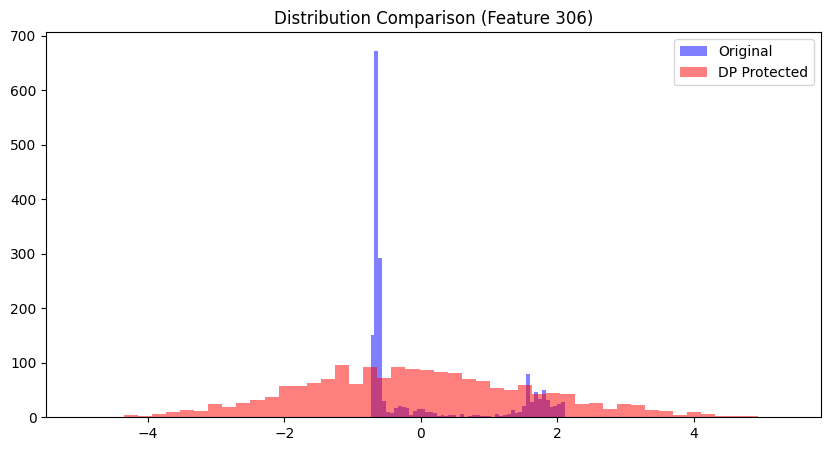

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(X_norm[:, top_indices], bins=50, alpha=0.5, label='Original', color='blue')
plt.hist(X_dp[:, top_indices], bins=50, alpha=0.5, label='DP Protected', color='red')
plt.title(f"Distribution Comparison (Feature {top_indices[0]})")
plt.legend()
plt.show()